## **Fake News Detection**

# Model Training

Import Library

In [55]:
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import pickle
import pandas as pd
import seaborn as sb
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Load dataset
# df_fake = pd.read_csv("../data/fake.csv")  # Update path as needed

# df_fake.head(10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Import Data

In [56]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "WELFake_Dataset.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "saurabhshahane/fake-news-classification",
  file_path,
)

df.head(10)

<ipython-input-56-8b95d4837ce7>:8: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
5,5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1
6,6,DR BEN CARSON TARGETED BY THE IRS: “I never ha...,DR. BEN CARSON TELLS THE STORY OF WHAT HAPPENE...,1
7,7,HOUSE INTEL CHAIR On Trump-Russia Fake Story: ...,,1
8,8,Sports Bar Owner Bans NFL Games…Will Show Only...,"The owner of the Ringling Bar, located south o...",1
9,9,Latest Pipeline Leak Underscores Dangers Of Da...,"FILE – In this Sept. 15, 2005 file photo, the ...",1


In [57]:
# file_path = "true.csv"
# # Load the latest version
# df_real = kagglehub.load_dataset(
#   KaggleDatasetAdapter.PANDAS,
#   "bhavikjikadara/fake-news-detection",
#   file_path,
# )

In [58]:
# df_fake['Label'] = 'False'
# df_real['Label'] = 'True'
# df = pd.concat([df_fake,df_real])
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [59]:
print(f'Data rows: {df.shape[0]}, Data columns: {df.shape[1]}')

Data rows: 72134, Data columns: 4


In [60]:
df.isna().sum()


,0
Unnamed: 0,0
title,558
text,39
label,0


In [61]:
df.duplicated().sum()

np.int64(0)

In [62]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
print(f'Data rows after cleaning: {df.shape[0]}, Data columns after cleaning: {df.shape[1]}')

Data rows after cleaning: 71537, Data columns after cleaning: 4


In [63]:
df = df.rename(columns={"text": "Statement"})

In [64]:
df = df.rename(columns={"label": "Label"})

In [65]:
df = df.sample(frac = 1)

In [66]:
df.head()

,Unnamed: 0,title,Statement,Label
20634,20634,Christian Gun Nut Shoots Unarmed Man Dead Dur...,.During the days of the Old West shooting an a...,1
47157,47157,Donald Trump and the Equilibrium to Come | New...,Region: USA in the World The news these last f...,1
14320,14320,Dem. Senator BLASTS Mitch McConnell For Exclu...,Senate Majority Leader Mitch McConnell (R-KY) ...,1
30384,30384,ECB's Rimsevics says Trump will be 'very good'...,RIGA (Reuters) - European Central Bank rateset...,0
60987,60987,Egypt's Muslim Brotherhood leader loses appeal...,CAIRO (Reuters) - The leader of Egypt s Muslim...,0


In [67]:
import string
def clean_text(text):
    # Converting all text to lowercase
    text = text.lower()

    # Delete link/URL
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text, flags=re.MULTILINE)

    # Delete emoji and characters non-ASCII
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)

    # Normalize Words
    text = re.sub(r"won\'t", "would not", text)
    text = re.sub(r"im", "i am", text)
    text = re.sub(r"Im", "i am", text)
    text = re.sub(r"dont", "do not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"don\'t", "do not", text)
    text = re.sub(r"shouldn\'t", "should not", text)
    text = re.sub(r"needn\'t", "need not", text)
    text = re.sub(r"hasn\'t", "has not", text)
    text = re.sub(r"haven\'t", "have not", text)
    text = re.sub(r"weren\'t", "were not", text)
    text = re.sub(r"mightn\'t", "might not", text)
    text = re.sub(r"didn\'t", "did not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    # Remove punctuation and other symbols
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)

    # Delete numbers
    text = re.sub(r'\d+', ' ', text)

    # Removing double spaces that may form
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()
    text = re.sub('\[.*?\]','',text)
    text = re.sub("\\W"," ",text)
    text = re.sub('https?://\S+|www\.\S+','',text)
    text = re.sub('<.*?>+',b'',text)
    text = re.sub('[%s]' % re.escape(string.punctuation),'',text)
    text = re.sub('\w*\d\w*','',text)
    return text
df['Statement'] = df['Statement'].apply(clean_text)

# Example usage
sample_text = "Breaking News! Fake news spreads quickly on social media."
print(clean_text(sample_text))

breaking news fake news spreads quickly on social media


In [68]:
df.sample(5)

,Unnamed: 0,title,Statement,Label
3684,3684,Crash Near Finish Throws Tour de France Into C...,france his bike crushed under a motorcycle s t...,0
38091,38091,"Syrian War Report – October 28, 2016: Militant...",trump s grandfather was a pi amp and tax evade...,1
40106,40106,The Pillow Cure - The New York Times,my neck is killing me isn t yours my shoulder ...,0
70175,70175,Presidential Debate: Here’s What You Missed - ...,we analyzed in real ti ame the second presiden...,0
54396,54396,"Report: Russian, U.S. Jets Have Close Encounte...",by wmw admin on october morgan chalfant washin...,1


In [69]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    words = text.split()
    processed_words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(processed_words)

df['Statement'] = df['Statement'].apply(preprocess_text)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71537 entries, 20634 to 65449
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  71537 non-null  int64 
 1   title       71537 non-null  object
 2   Statement   71537 non-null  object
 3   Label       71537 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.7+ MB


In [71]:
df = df[['Statement', 'Label']]
df.head()

,Statement,Label
20634,day old west shoot unarm man violat code cowbo...,1
47157,region usa world news last day radic left arm ...,1
14320,senat major leader mitch mcconnel r ky announc...,1
30384,riga reuter european central bank ratesett ilm...,0
60987,cairo reuter leader egypt musli brotherhood mo...,0


<ipython-input-72-9bf9efb7e872>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  return sb.countplot(x='Label', data=dataFile, palette='hls')


<Axes: xlabel='Label', ylabel='count'>

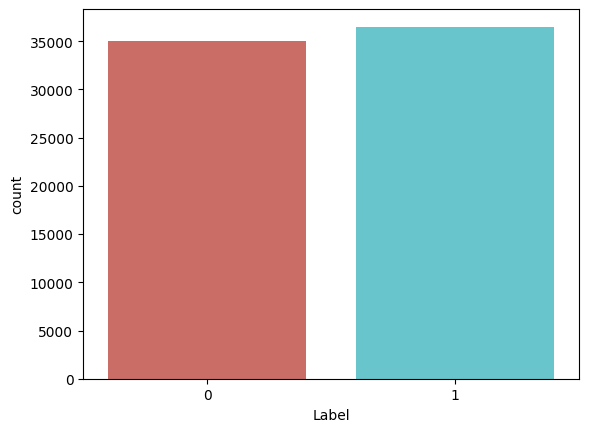

In [72]:
def create_distribution(dataFile):
    return sb.countplot(x='Label', data=dataFile, palette='hls')

# by calling below we can see that training, test and valid data seems to be failry evenly distributed between the classes
create_distribution(df)

In [73]:
def data_qualityCheck():
    print("Checking data qualitites...")
    df.isnull().sum()
    df.info()
    print("check finished.")
data_qualityCheck()

df = df.dropna()

Checking data qualitites...
<class 'pandas.core.frame.DataFrame'>
Index: 71537 entries, 20634 to 65449
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Statement  71537 non-null  object
 1   Label      71537 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ MB
check finished.


In [74]:
print(df.columns)
df.shape
print(df.columns)

Index(['Statement', 'Label'], dtype='object')
Index(['Statement', 'Label'], dtype='object')


In [75]:
print(df.columns)
df.reset_index(drop= True,inplace=True)
df.head(10)

Index(['Statement', 'Label'], dtype='object')


,Statement,Label
0,day old west shoot unarm man violat code cowbo...,1
1,region usa world news last day radic left arm ...,1
2,senat major leader mitch mcconnel r ky announc...,1
3,riga reuter european central bank ratesett ilm...,0
4,cairo reuter leader egypt musli brotherhood mo...,0
5,washington reuter five u republican lawmak rai...,0
6,fm iran syria russia meet moscow fri oct polit...,1
7,post eddi beer add longev strengthen bone wher...,1
8,washington reuter u presid donald trump said w...,0
9,beij reuter china express seriou concern monda...,0


In [76]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df.Label = label_encoder.fit_transform(df.Label)

In [77]:
Label_train = df.Label


In [78]:
Label_train.head(10)


,Label
0,1
1,1
2,1
3,0
4,0
5,0
6,1
7,1
8,0
9,0


In [79]:
# df.drop('Label', axis=1, inplace=True)

In [80]:
df.head(10)

,Statement,Label
0,day old west shoot unarm man violat code cowbo...,1
1,region usa world news last day radic left arm ...,1
2,senat major leader mitch mcconnel r ky announc...,1
3,riga reuter european central bank ratesett ilm...,0
4,cairo reuter leader egypt musli brotherhood mo...,0
5,washington reuter five u republican lawmak rai...,0
6,fm iran syria russia meet moscow fri oct polit...,1
7,post eddi beer add longev strengthen bone wher...,1
8,washington reuter u presid donald trump said w...,0
9,beij reuter china express seriou concern monda...,0


In [81]:
df['Statement'][2188]

'custom burger king hope get refund shake one respond plea help ask speak manag burger king manag treat truli shock whatev happen custom servic whatev happen american proud elev posit manag whatev happen civil'

In [82]:
Label_train

,Label
0,1
1,1
2,1
3,0
4,0
...,...
71532,0
71533,1
71534,1
71535,0


In [83]:
lemmatizer = WordNetLemmatizer()
stpwrds = list(stopwords.words('english'))

In [84]:
stpwrds

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [85]:
print(df.columns)

Index(['Statement', 'Label'], dtype='object')


In [86]:
for x in range(len(df)) :
    corpus = []
    review = df['Statement'][x]
    review = re.sub(r'[^a-zA-Z\s]', '', review)
    review = review.lower()
    review = nltk.word_tokenize(review)
    for y in review :
        if y not in stpwrds :
            corpus.append(lemmatizer.lemmatize(y))
    review = ' '.join(corpus)
    df.loc[x,'Statement'] = review

In [87]:
Statement_train = df.Statement

In [88]:
Statement_train.head()

,Statement
0,day old west shoot unarm man violat code cowbo...
1,region usa world news last day radic left arm ...
2,senat major leader mitch mcconnel r ky announc...
3,riga reuter european central bank ratesett ilm...
4,cairo reuter leader egypt musli brotherhood mo...


In [89]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(Statement_train, Label_train, test_size=0.4, random_state=42)

In [90]:
X_train.shape, y_train.shape

((42922,), (42922,))

In [91]:
X_train

,Statement
48726,pari reuter hundr woman attend ralli pari fren...
53522,washington reuter u hous repres speaker paul r...
58584,donald trump gave first press confer sinc elec...
16233,berlin reuter german chancellor angela merkel ...
43127,ok clinton back bad thing back good thing what...
...,...
37194,vienna reuter iran remain within main li amit ...
6265,washington reuter u presid barack obama tuesda...
54886,good morn want get california today email sign...
860,look close might find familiar hypocrit call n...


In [92]:
y_train

,Label
48726,0
53522,0
58584,1
16233,0
43127,0
...,...
37194,0
6265,0
54886,0
860,1


In [93]:
X_test

,Statement
53925,nation uproar wednesday learn donald trump div...
6939,tomi lahren overli emot angri vitriol face new...
28713,year obama administr prod cajol beseech china ...
65420,washington reuter u ammigr enforc offic propos...
2286,thank good musli woman friend socialist radic ...
...,...
18834,virginia trump campaign chairman politic dalla...
12538,democrat reportedli furiou deputi attorney gen...
19011,secondari verif googl com dki key fwd thought ...
21501,reuter lawmak kansa monday fail overrid republ...


In [94]:
X_test.shape, y_test.shape

((28615,), (28615,))

In [95]:
# Preprocessing
vectorizer = TfidfVectorizer(stop_words='english',max_features=5000)
vec_X_train = vectorizer.fit_transform(X_train)
vec_X_test = vectorizer.transform(X_test)

# Save the trained vectorizer
# with open("../models/tfidf_vectorizer2.pkl", "wb") as file:
#     pickle.dump(vectorizer, file)

In [96]:
vec_X_train.shape, vec_X_test.shape

((42922, 5000), (28615, 5000))

In [97]:
import itertools

import numpy as np


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [98]:
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Step 1: Base models
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=0, n_estimators=100),
    "GradientBoosting": GradientBoostingClassifier(random_state=0),
    "PassiveAggressive": PassiveAggressiveClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Step 2: Add SVMs with different C values
svm_c_values = [0.1, 1, 10]
for c in svm_c_values:
    models[f"SVM (C={c})"] = SVC(kernel='linear', C=c)


In [99]:
import numpy as np
from sklearn import metrics

accuracies = {}
for name, model in models.items():
    model.fit(vec_X_train, y_train)
    y_pred = model.predict(vec_X_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    accuracies[name] = acc
    print(f'{name} Accuracy: {round(acc*100,2)}%')

    # Save model
    # with open(f"../models/{name.replace(' ', '_').lower()}.pkl", "wb") as f:
    #     pickle.dump(model, f)

Naive Bayes Accuracy: 83.38%
Logistic Regression Accuracy: 92.85%
Random Forest Accuracy: 92.82%
GradientBoosting Accuracy: 91.48%
PassiveAggressive Accuracy: 92.4%


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:58:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 94.85%


KeyboardInterrupt: 

In [ ]:
# Plot improved accuracy comparison graph
plt.figure(figsize=(10,5))
bars = plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green', 'red', 'purple', 'orange'])

# Adding value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{round(yval*100,2)}", ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=45)
plt.ylim(0.8, 1)  # Accuracy y-axis ranges from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=1)

plt.show()


# Model Testing

In [ ]:
print(models)

In [ ]:
import pandas as pd

def output_label(n):
    return "Fake News" if n == 0 else "Not A Fake News"

def manual_testing(news):
    # Ensure 'models' contains trained models
    for name, model in models.items():  # FIXED: Use `models.items()` instead of `models()`

        # Create a DataFrame for input news
        testing_news = {"text": [news]}
        new_def_test = pd.DataFrame(testing_news)

        # Apply text preprocessing (Ensure 'clean_text' is defined)
        new_def_test['text'] = new_def_test["text"].apply(clean_text)

        # Transform input using the loaded vectorizer
        new_xv_test = vectorizer.transform(new_def_test["text"])

        # Get model predictions
        test_pred = model.predict(new_xv_test)

        # Print prediction correctly
        print(f"{name} Prediction: {output_label(test_pred[0])}")  # FIXED: Index test_pred

In [ ]:
news ="Federal health officials told the AP they have not received any reports of Ebola cases at the Nevada event. A screenshot of a supposed post from the Centers for Disease Control and Prevention confirming such cases was fabricated. And there is no record of a national emergency being declared. The claims emerged after summer storm left muddy roads flooded, stranding tens of thousands of partygoers; event organizers let traffic flow out of the main road Monday afternoon. “So it was announced earlier that Burning Man was declared a national emergency because it was flooded, and so they sent in FEMA,” a woman claims in a TikTok video shared on Instagram, suggesting the development was suspicious. The AP found no record, including on federal websites and in White House announcements, of a national emergency declaration and FEMA confirmed that it was not involved in the situation. “No FEMA personnel or assets have been deployed to the Burning Man festival and there are no requests from local or state authorities for our assistance,” FEMA spokesperson Jeremy Edwards said in an email. The TikTok video, like other posts, goes on to relay baseless rumors of reported cases of Ebola, whose occasional outbreaks in humans primarily occur in Africa, at the festival. Some posts also shared an image made to appear that the CDC confirmed the supposed outbreak on X, the platform formerly known as Twitter. The purported X post from the agency reads, “Ebola outbreak confirmed at Black Rock City, NV. It is recommended that all Burning Man attendees remain in their dwellings until further notice. Current State of Emergency in progress.” But the CDC’s X account published no such post. “CDC has not received any reports of Ebola at the Burning Man Festival and has not issued any warnings or had any requests for assistance from the state and local health departments either,” agency spokesperson Scott Pauley said in an email. Reverse image searches further show that a graphic about Ebola used in the fictitious CDC post was published by the agency in 2016, but elements of it were changed. For example, the original graphic asks, “Recently in West Africa?” But the version used in the made-up X post asks, “Recently in Nevada?” Referencing more online rumors, Pauley also noted the CDC had not received reports of mpox, formerly known as monkeypox, or Marburg, a rare but severe hemorrhagic fever, in relation to Burning Man. A representative for the Burning Man Project organization also refuted the online claims. “Quite simply, the online rumors of transmissible illnesses in Black Rock City are unfounded and untrue,” Dominique Debucquoy-Dodley said in an email. The festival had been closed to vehicles after more than a half-inch (1.3 centimeters) of rain fell Sept. 1, causing flooding and foot-deep mud, as the AP reported. The annual gathering, which launched on a San Francisco beach in 1986, attracts nearly 80,000 artists, musicians and activists for a mix of wilderness camping and avant-garde performances"
manual_testing(news)

In [ ]:
news = "MOSCOW (Reuters) - Russiaâ€™s former ambassador to Washington, Sergei Kislyak, said on Saturday his conversations with former White House national security adviser Michael Flynn had been transparent and focused on matters of U.S.-Russia cooperation. Kislyak ended his tenure in Washington in July but remains a key figure in ongoing U.S. investigations into Moscowâ€™s alleged meddling in the 2016 presidential election. Flynn was forced to resign in February after it became known that he had failed to disclose the content of conversations he had with Kislyak and misled U.S. Vice-President Mike Pence about their meetings. â€œWe only spoke about the most simple things ... but the communication was completely correct, calm, absolutely transparent. In any case, there were no secrets on our side,â€ Kislyak said during a panel discussion on Russian television. â€œThere are a number of issues which are important for cooperation between Russia and the United States - most of all, terrorism. And that was one of the things we discussed.â€"
manual_testing(news)